# Gaussian mixture models

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

## Advantage & Disadvantage

### Advantage

- Fastest algorithm for learning mixture models
- As this algorithm maximizes only the likelihood, it will not bias the means towards zero, or bias the cluster sizes to have specific structures that might or might not apply.

### Disadvantage

- When one has insufficiently many points per mixture, estimating the covariance matrices becomes difficult, and the algorithm is known to diverge and find solutions with infinite likelihood unless one regularizes the covariances artificially.
- This algorithm will always use all the components it has access to, needing held-out data or information theoretical criteria to decide how many components to use in the absence of external cues.

## Usage

The GaussianMixture comes with different options to constrain the covariance of the difference classes estimated: spherical, diagonal, tied or full covariance.

Here is a sample code

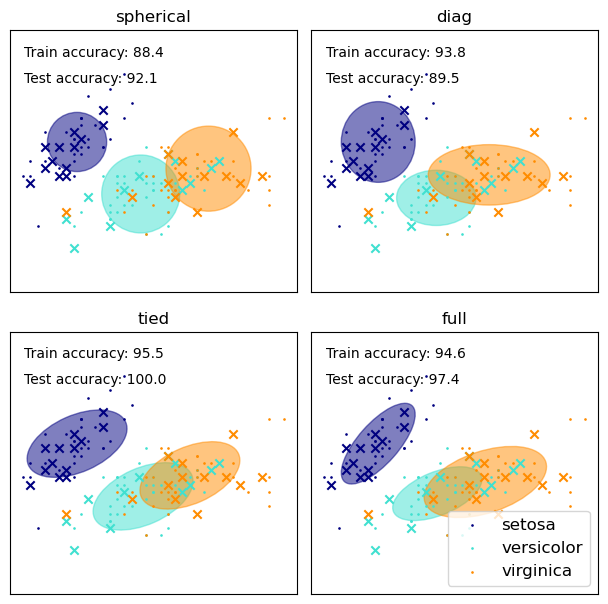

In [4]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ["navy", "turquoise", "darkorange"]


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")


iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(
            data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n]
        )
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))


plt.show()

## Selecting the number of components in a classical Gaussian Mixture Model

The BIC criterion can be used to select the number of components in a Gaussian Mixture in an efficient way. In theory, it recovers the true number of components only in the asymptotic regime (i.e. if much data is available and assuming that the data was actually generated i.i.d. from a mixture of Gaussian distribution). Note that using a Variational Bayesian Gaussian mixture avoids the specification of the number of components for a Gaussian mixture model.

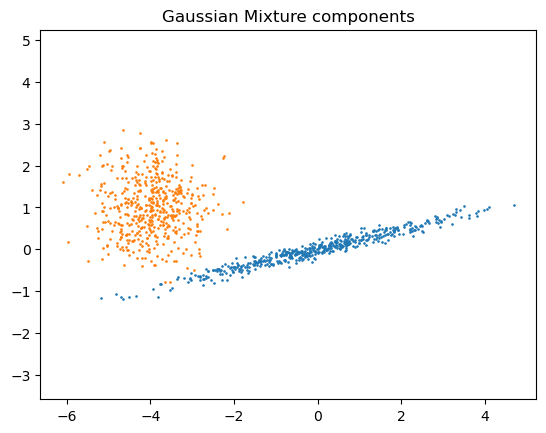

In [5]:
# We generate two components (each one containing n_samples) by randomly sampling the standard normal distribution as returned by numpy.random.randn. One component is kept spherical yet shifted and re-scaled. The other one is deformed to have a more general covariance matrix.

import numpy as np

n_samples = 500
np.random.seed(0)
C = np.array([[0.0, -0.1], [1.7, 0.4]])
component_1 = np.dot(np.random.randn(n_samples, 2), C)  # general
component_2 = 0.7 * np.random.randn(n_samples, 2) + np.array([-4, 1])  # spherical

X = np.concatenate([component_1, component_2])

import matplotlib.pyplot as plt

plt.scatter(component_1[:, 0], component_1[:, 1], s=0.8)
plt.scatter(component_2[:, 0], component_2[:, 1], s=0.8)
plt.title("Gaussian Mixture components")
plt.axis("equal")
plt.show()

   Number of components Type of covariance    BIC score
19                    2               full  1046.830484
20                    3               full  1083.619771
21                    4               full  1115.506903
22                    5               full  1148.852331
23                    6               full  1183.684082
15                    4               diag  1240.655084
16                    5               diag  1252.741762
14                    3               diag  1253.108315
17                    6               diag  1254.734653
11                    6               tied  1259.686335
13                    2               diag  1296.637751
10                    5               tied  1299.429365
4                     5          spherical  1326.944214
3                     4          spherical  1329.922469
5                     6          spherical  1344.843924
9                     4               tied  1370.039967
2                     3          spherical  1382

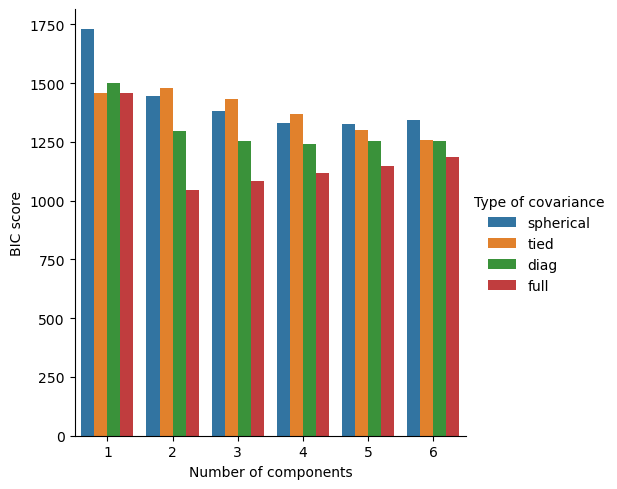

In [11]:
# We score the different models and keep the best model (the lowest BIC). This is done by using GridSearchCV and a user-defined score function which returns the negative BIC score, as GridSearchCV is designed to maximize a score (maximizing the negative BIC is equivalent to minimizing the BIC).

#The best set of parameters and estimator are stored in best_parameters_ and best_estimator_, respectively.

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X)

import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
print(df.sort_values(by="BIC score"))

import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()
#In the present case, the model with 2 components and full covariance (which corresponds to the true generative model) has the lowest BIC score and is therefore selected by the grid search.

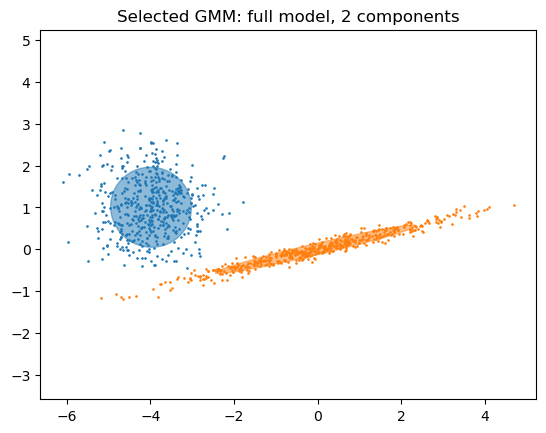

In [7]:
from matplotlib.patches import Ellipse
from scipy import linalg

color_iter = sns.color_palette("tab10", 2)[::-1]
Y_ = grid_search.predict(X)

fig, ax = plt.subplots()

for i, (mean, cov, color) in enumerate(
    zip(
        grid_search.best_estimator_.means_,
        grid_search.best_estimator_.covariances_,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

plt.title(
    f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
    f"{grid_search.best_params_['n_components']} components"
)
plt.axis("equal")
plt.show()

##  Estimation algorithm Expectation-maximization

The main difficulty in learning Gaussian mixture models from unlabeled data is that one usually doesn’t know which points came from which latent component (if one has access to this information it gets very easy to fit a separate Gaussian distribution to each set of points). Expectation-maximization is a well-founded statistical algorithm to get around this problem by an iterative process. First one assumes random components (randomly centered on data points, learned from k-means, or even just normally distributed around the origin) and computes for each point a probability of being generated by each component of the model. Then, one tweaks the parameters to maximize the likelihood of the data given those assignments. Repeating this process is guaranteed to always converge to a local optimum.

### Choice of the Initialization Method

- k-means (default): time-consuming
- k-means++: still time-consuming
- random_from_data: fast but may not converge
- random: simple but time consuming

Automatically created module for IPython interactive environment


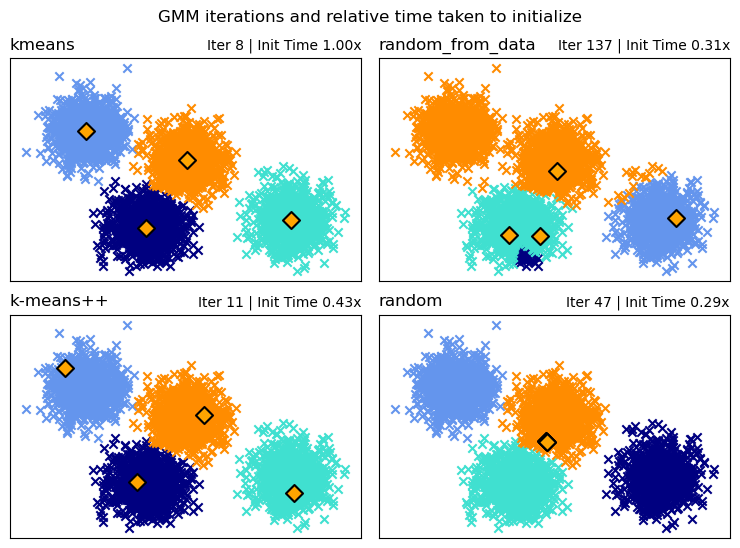

In [12]:
# Author: Gordon Walsh <gordon.p.walsh@gmail.com>
# Data generation code from Jake Vanderplas <vanderplas@astro.washington.edu>

from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets._samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.utils.extmath import row_norms

print(__doc__)

# Generate some data

X, y_true = make_blobs(n_samples=4000, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1]

n_samples = 4000
n_components = 4
x_squared_norms = row_norms(X, squared=True)


def get_initial_means(X, init_params, r):
    # Run a GaussianMixture with max_iter=0 to output the initialization means
    gmm = GaussianMixture(
        n_components=4, init_params=init_params, tol=1e-9, max_iter=0, random_state=r
    ).fit(X)
    return gmm.means_


methods = ["kmeans", "random_from_data", "k-means++", "random"]
colors = ["navy", "turquoise", "cornflowerblue", "darkorange"]
times_init = {}
relative_times = {}

plt.figure(figsize=(4 * len(methods) // 2, 6))
plt.subplots_adjust(
    bottom=0.1, top=0.9, hspace=0.15, wspace=0.05, left=0.05, right=0.95
)

for n, method in enumerate(methods):
    r = np.random.RandomState(seed=1234)
    plt.subplot(2, len(methods) // 2, n + 1)

    start = timer()
    ini = get_initial_means(X, method, r)
    end = timer()
    init_time = end - start

    gmm = GaussianMixture(
        n_components=4, means_init=ini, tol=1e-9, max_iter=2000, random_state=r
    ).fit(X)

    times_init[method] = init_time
    for i, color in enumerate(colors):
        data = X[gmm.predict(X) == i]
        plt.scatter(data[:, 0], data[:, 1], color=color, marker="x")

    plt.scatter(
        ini[:, 0], ini[:, 1], s=75, marker="D", c="orange", lw=1.5, edgecolors="black"
    )
    relative_times[method] = times_init[method] / times_init[methods[0]]

    plt.xticks(())
    plt.yticks(())
    plt.title(method, loc="left", fontsize=12)
    plt.title(
        "Iter %i | Init Time %.2fx" % (gmm.n_iter_, relative_times[method]),
        loc="right",
        fontsize=10,
    )
plt.suptitle("GMM iterations and relative time taken to initialize")
plt.show()

## Variational Bayesian Gaussian Mixture

The BayesianGaussianMixture object implements a variant of the Gaussian mixture model with variational inference algorithms.

### Advantage & Disadvantage

- Advantage
  - when weight_concentration_prior is small enough and n_components is larger than what is found necessary by the model, the Variational Bayesian mixture model has a natural tendency to set some mixture weights values close to zero. This makes it possible to let the model choose a suitable number of effective components automatically. Only an upper bound of this number needs to be provided. Note however that the “ideal” number of active components is very application specific and is typically ill-defined in a data exploration setting.
  - unlike finite models, which will almost always use all components as much as they can, and hence will produce wildly different solutions for different numbers of components, the variational inference with a Dirichlet process prior (weight_concentration_prior_type='dirichlet_process') won’t change much with changes to the parameters, leading to more stability and less tuning.
  - due to the incorporation of prior information, variational solutions have less pathological special cases than expectation-maximization solutions.
- Disadvantage
  - the extra parametrization necessary for variational inference makes inference slower, although not by much.
  - this algorithm needs an extra hyperparameter that might need experimental tuning via cross-validation.
  - there are many implicit biases in the inference algorithms (and also in the Dirichlet process if used), and whenever there is a mismatch between these biases and the data it might be possible to fit better models using a finite mixture.

In [ ]:
# Author: Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from sklearn.mixture import BayesianGaussianMixture


def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(
            means[n], eig_vals[0], eig_vals[1], angle=180 + angle, edgecolor="black"
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor("#56B4E9")
        ax.add_artist(ell)


def plot_results(ax1, ax2, estimator, X, y, title, plot_title=False):
    ax1.set_title(title)
    ax1.scatter(X[:, 0], X[:, 1], s=5, marker="o", color=colors[y], alpha=0.8)
    ax1.set_xlim(-2.0, 2.0)
    ax1.set_ylim(-3.0, 3.0)
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_, estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction="out")
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(estimator.weights_):
        ax2.bar(
            k,
            w,
            width=0.9,
            color="#56B4E9",
            zorder=3,
            align="center",
            edgecolor="black",
        )
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.0), horizontalalignment="center")
    ax2.set_xlim(-0.6, 2 * n_components - 0.4)
    ax2.set_ylim(0.0, 1.1)
    ax2.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
    ax2.tick_params(axis="x", which="both", top=False)

    if plot_title:
        ax1.set_ylabel("Estimated Mixtures")
        ax2.set_ylabel("Weight of each component")


# Parameters of the dataset
random_state, n_components, n_features = 2, 3, 2
colors = np.array(["#0072B2", "#F0E442", "#D55E00"])

covars = np.array(
    [[[0.7, 0.0], [0.0, 0.1]], [[0.5, 0.0], [0.0, 0.1]], [[0.5, 0.0], [0.0, 0.1]]]
)
samples = np.array([200, 500, 200])
means = np.array([[0.0, -0.70], [0.0, 0.0], [0.0, 0.70]])

# mean_precision_prior= 0.8 to minimize the influence of the prior
estimators = [
    (
        "Finite mixture with a Dirichlet distribution\nprior and " r"$\gamma_0=$",
        BayesianGaussianMixture(
            weight_concentration_prior_type="dirichlet_distribution",
            n_components=2 * n_components,
            reg_covar=0,
            init_params="random",
            max_iter=1500,
            mean_precision_prior=0.8,
            random_state=random_state,
        ),
        [0.001, 1, 1000],
    ),
    (
        "Infinite mixture with a Dirichlet process\n prior and" r"$\gamma_0=$",
        BayesianGaussianMixture(
            weight_concentration_prior_type="dirichlet_process",
            n_components=2 * n_components,
            reg_covar=0,
            init_params="random",
            max_iter=1500,
            mean_precision_prior=0.8,
            random_state=random_state,
        ),
        [1, 1000, 100000],
    ),
]

# Generate data
rng = np.random.RandomState(random_state)
X = np.vstack(
    [
        rng.multivariate_normal(means[j], covars[j], samples[j])
        for j in range(n_components)
    ]
)
y = np.concatenate([np.full(samples[j], j, dtype=int) for j in range(n_components)])

# Plot results in two different figures
for title, estimator, concentrations_prior in estimators:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(
        bottom=0.04, top=0.90, hspace=0.05, wspace=0.05, left=0.03, right=0.99
    )

    gs = gridspec.GridSpec(3, len(concentrations_prior))
    for k, concentration in enumerate(concentrations_prior):
        estimator.weight_concentration_prior = concentration
        estimator.fit(X)
        plot_results(
            plt.subplot(gs[0:2, k]),
            plt.subplot(gs[2, k]),
            estimator,
            X,
            y,
            r"%s$%.1e$" % (title, concentration),
            plot_title=k == 0,
        )

plt.show()

In [ ]:
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9.0, 5.0)
    plt.ylim(-3.0, 6.0)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0.0, -0.1], [1.7, 0.4]])
X = np.r_[
    np.dot(np.random.randn(n_samples, 2), C),
    0.7 * np.random.randn(n_samples, 2) + np.array([-6, 3]),
]

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type="full").fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, "Gaussian Mixture")

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=5, covariance_type="full").fit(X)
plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    1,
    "Bayesian Gaussian Mixture with a Dirichlet process prior",
)

plt.show()

In [ ]:
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])


def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6.0, 4.0 * np.pi - 6.0)
    plt.ylim(-5.0, 5.0)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)

    plt.xlim(-6.0, 4.0 * np.pi - 6.0)
    plt.ylim(-5.0, 5.0)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


# Parameters
n_samples = 100

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))
step = 4.0 * np.pi / n_samples

for i in range(X.shape[0]):
    x = i * step - 6.0
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3.0 * (np.sin(x) + np.random.normal(0, 0.2))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(
    bottom=0.04, top=0.95, hspace=0.2, wspace=0.05, left=0.03, right=0.97
)

# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(
    n_components=10, covariance_type="full", max_iter=100
).fit(X)
plot_results(
    X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, "Expectation-maximization"
)

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10,
    covariance_type="full",
    weight_concentration_prior=1e-2,
    weight_concentration_prior_type="dirichlet_process",
    mean_precision_prior=1e-2,
    covariance_prior=1e0 * np.eye(2),
    init_params="random",
    max_iter=100,
    random_state=2,
).fit(X)
plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    1,
    "Bayesian Gaussian mixture models with a Dirichlet process prior "
    r"for $\gamma_0=0.01$.",
)

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(
    X_s,
    y_s,
    dpgmm.n_components,
    0,
    "Gaussian mixture with a Dirichlet process prior "
    r"for $\gamma_0=0.01$ sampled with $2000$ samples.",
)

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10,
    covariance_type="full",
    weight_concentration_prior=1e2,
    weight_concentration_prior_type="dirichlet_process",
    mean_precision_prior=1e-2,
    covariance_prior=1e0 * np.eye(2),
    init_params="kmeans",
    max_iter=100,
    random_state=2,
).fit(X)
plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    2,
    "Bayesian Gaussian mixture models with a Dirichlet process prior "
    r"for $\gamma_0=100$",
)

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(
    X_s,
    y_s,
    dpgmm.n_components,
    1,
    "Gaussian mixture with a Dirichlet process prior "
    r"for $\gamma_0=100$ sampled with $2000$ samples.",
)

plt.show()